
# scATAC 分析教程
作者：马雯

# 1. 建库过程

## 1.1 Tn5酶构建ATAC-seq文库原理
Tn5转座子由编码抗性基因的核心序列和两条倒置的IS50 序列组成，其中IS50R和IS50L的序列高度同源，含有编码转座酶（TnP）以及转座阻遏蛋白（lnh）的基因，但IS50L的一个碱基存在突变导致翻译提前终止，因此只有IS50R可以产生正常的有活性的TnP和lnh。IS50具有19bp的倒置末端（外末端outsideend，OE和内末端inside end，IE），两倒置末端有7个bp不同，此倒置末端是转座酶（Tnp）的作用位点。发生转座事件时，两个转座子酶（Tnp）与转座子末端OE末端结合，形成两个Tnp-OE复合体，随后两个复合体通过Tnp的C末端相互作用进行联会，形成一个Tn5转座复合体后产生切割DNA的活性。具有切割DNA活性之后，切割目标DNA，将转座子插入到靶序列中，粘性末端通过DNA聚合酶、连接酶作用进行填补，两端形成9bp正向重复序列。

<center>
<img src="https://d3i71xaburhd42.cloudfront.net/d42684719a35a2ae3981d6a3b6bcc84f27d5f854/2-Figure1-1.png" width=500>
</center>

研究人员发现，整个转座子序列并不是转座必须的，只需转座子的末端核心序列，转座酶便能将该部分序列插入并连接至基因组内；根据这个原理，将测序接头序列加入末端核心序列中，可简捷地引入测序接头，完成文库构建。传统建库方式需要经过DNA片段化、末端修复、接头连接、文库扩增、多次纯化分选等步骤，耗时较长，将Tn5用于测序文库构建时，可将DNA片段化、末端修复、接头连接等多步反应转变为1步反应，极大缩短建库时间，提高工作效率。
<center>
<img src="https://teichlab.github.io/scg_lib_structs/data/tn5_dimer.svg" width="438">
<img src="https://s2.loli.net/2022/08/23/cH3OeC6lVKRL9aG.jpg" width="438">
</center>

## 1.2单细胞ATAC-seq建库过程
下图为DNBelab C系列高通量单细胞ATAC文库构建测序流程。基于负压驱动的液滴微流控系统，结合自主设计的高密度微珠，可以实现对单细胞进行高通量barcoding 首先，制备高质量的单细胞核悬液，保证活率在80%以上；然后，将制备好的单细胞核悬液、用于捕获单细胞DNA片段的barcode标记的磁珠和液滴生成油上样到便携式微流控装置中。该装置能生成大量油包水液滴，每个液滴中理想状态下包含一个beads和一个cell，在液滴中Tn5酶进入细胞核将开放染色质打断，释放DNA片段，DNA片段被磁珠捕获，同一个cell的DNA片段会被带上相同的barcode分子标签，实现了单个细胞的标记。
<center>
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/C4_library.png"  alt="Smiley face" width="1000">
</center>

<center>
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/scATAC_library.jpg" width="1000">
</center>

# 2. scATAC 自动化分析V3系统分析过程与结果

流程概述

<center>
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/pipeline.png"  width="669">
</center>
## 2.0 数据结构

-   read1 70bp； 1-20bp barcode序列，21-70bp DNA序列

-   read2 50bp； 1-50bp DNA序列
 
 <center>                                                                                                                     
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/fq1.jpg"  width="669">
</center>
  <center>
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/fq2.jpg"  width="669">
  </center>

## 2.1 比对

使用chromap进行比对 chromap[**参考文献**](https://www.nature.com/articles/s41467-021-26865-w)

-   chromap 的优点

1.  比对速度较bwa mem2 提升了10倍

2.  比对准确性与bwa mem2相当
 <center> 
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/chromap.png"  width="669">  
</center>   
-   chromap 比对过程

1.  识别barcode，与whitelist匹配，不匹配的read不再进行比对（目前不允许有mismatch）

2.  去除adapter

3.  DNA序列比对到参考基因组上

4.  比对结果文件（out/aln.bed）
<center>
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/%E6%AF%94%E5%AF%B9%E7%BB%93%E6%9E%9C%E6%96%87%E4%BB%B6.png"  width="507">
</center>

## 2.2 去除背景

捕获到完整细胞的beads与没有捕获到细胞或捕获到破裂细胞的beads中fragment数目差异较大，因此对每个beads中捕获到的fragment数目进行排序，如果fragment数目突然减少（骤降），骤降点以下的beads为空beads；以下图为例，蓝色区域为完整细胞，灰色区域为空beads或破损细胞
<center> 
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/%E9%AA%A4%E9%99%8D_1.jpg"  width="439">
</center> 

## 2.3 beads合并

在实验过程中为获取更多的细胞，会投入较多的beads，从而造成一个液滴中多个beads的现象。为还原真实的细胞染色质开放信息，使用d2c根据beads中fragment中的相似性进行beads 合并，[**参考文献**](https://www.nature.com/articles/s41467-020-14667-5)

-  液滴中出现捕捉多个beads一个细胞的情况
 
 <center>                                                                                                                                  
 <img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/beads_marged.png"  width="468"> 
 </center>  

-  通过计算两个beads之间相似性（jaccard index），推测beads来源于同一个液滴
 
   

 <center> 
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/bap.png"  width="1200">
 </center> 


## 2.4 peak calling

peak calling是通过计算方法识别基因组中由测序得到的比对reads富集的区域，对ATAC而言，peak为开放染色质的区域。 目前流程使用基于reads count的方法macs2来做peak calling
<center>
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/peak_calling.jpg"  width="242">
</center>

# 3. 使用ArchR进行scATAC下游分析

本教程例子选用PBMC样本

    
### 3.1 加载R包并获取gene和基因组信息

加载ArchR 包 设置线程 设置种子数

In [1]:

library(ArchR)
library(parallel)
library(Seurat)

library(pryr) 
addArchRThreads(threads = 16)
set.seed(1)



                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

添加ArchRGenome

对于human和mouse这两个物种可直接通过addArchRGenome添加

**tips：gene与genome 的版本要与reads比对参考基因组的版本一致**

In [2]:
setwd('/')
# 本例为添加hg38
addArchRGenome("hg38")
# addArchRGenome("hg19")
# addArchRGenome("mm9")
# addArchRGenome("mm10")

Setting default genome to Hg38.



对于非人非鼠的物种，可自己构建ArchRGenome

以果蝇（*Drosophila melanogaster*）为例

创建genome annotation文件

In [3]:

if (!requireNamespace("BSgenome.Dmelanogaster.UCSC.dm6", quietly = TRUE)){
  BiocManager::install("BSgenome.Dmelanogaster.UCSC.dm6")
}
library(BSgenome.Dmelanogaster.UCSC.dm6)
genomeAnnotation <- createGenomeAnnotation(genome = BSgenome.Dmelanogaster.UCSC.dm6)

#genomeAnnotation可以保存成rds文件，下次使用直接加载rds使用不需要每次都构建

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer

Getting genome..

Attempting to infer chromSizes..

Attempting to infer blacklist..

Blacklist not downloaded! Continuing without, be careful for downstream biases..



创建gene annotation文件

In [4]:

library("TxDb.Dmelanogaster.UCSC.dm6.ensGene")
library("org.Dm.eg.db")
geneAnnotation <- createGeneAnnotation(TxDb = TxDb.Dmelanogaster.UCSC.dm6.ensGene, OrgDb = org.Dm.eg.db)
#geneAnnotation可以保存成rds文件，下次使用直接加载rds使用不需要每次都构建

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi



Getting Genes..

  1 gene was dropped because it has exons located on both strands of the
  same reference sequence or on more than one reference sequence, so
  cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

Determined Annotation Style = ENSEMBL

Getting Exons..

Getting TSS..



### 3.2 创建arrowfiles

#### 3.2.1 ArrowFiles

ArrowFiles是存储在硬盘中的H5文件，其中包含有细胞的metadata信息、fragment信息、500bp Tile Matrix、GeneActivityScore Matrix、Peak Count Matrix 等一系列信息；由于scATAC 矩阵更加的稀疏，相应所占空间更多，为加速R的运算，这些信息会存储在ArrowFiles文件中，使用时通过读取ArrowFiles文件来获取信息，促使ArchRProject文件大小较小，减少内存占用。

<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/ArrowFiles.png">

#### 3.2.2 使用fragment文件创建ArrowFiles

可使用bed格式的fragment 文件和bam文件进行ArrowFiles文件的创建。此例中使用bed格式的fragment文件进行ArrowFiles的创建。

> bam文件中reads没有经过+4-5处理，默认加入offsetPlus = 4,offsetMinus = -5 产生真实的fragment片段。这两个参数对BED文件不起作用

In [5]:

setwd('/home/jovyan')
# fragment 文件读入
inputdir="/opt/example/00.scATAC_data/"
first_name <- list.files(inputdir,"tsv.gz$")
sample_name <- gsub(".fragments.tsv.gz","",first_name)
FragmentFiles <- paste(inputdir,first_name,sep="/")
names(FragmentFiles) <- sample_name

## 15 min 1.15G内存
ArrowFiles <- createArrowFiles(
 inputFiles = FragmentFiles,
 minFrags = 1000, #Dont","set","this","too","high","because","you","can","always","increase","later
 minTSS = 4,
 addTileMat = TRUE,
 addGeneScoreMat = TRUE,
 threads = 1,
 force = T
)


Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-3a24ac710f-Date-2022-08-23_Time-03-20-22.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2022-08-23 03:20:22 : Batch Execution w/ safelapply!, 0 mins elapsed.

(0607-ATAC-PBMC-ZYH-0302-2 : 1 of 1) Determining Arrow Method to use!

2022-08-23 03:20:22 : (0607-ATAC-PBMC-ZYH-0302-2 : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.001 mins elapsed.

2022-08-23 03:20:22 : (0607-ATAC-PBMC-ZYH-0302-2 : 1 of 1) Tabix Bed To Temporary File, 0.001 mins elapsed.

2022-08-23 03:21:06 : (0607-ATAC-PBMC-ZYH-0302-2 : 1 of 1) Reading TabixFile 8 Percent, 0.724 mins elapsed.

2022-08-23 03:21:36 : (0607-ATAC-PBMC-ZYH-0302-2 : 1 of 1) Reading TabixFile 17 Percent, 1.227 mins elapsed.

2022-08-23 03:22:04 : (0607-ATAC-PBMC-ZYH-0302-2 : 1 of 1) Reading TabixFile 25 Percent, 1.688 mins elapsed.



<img src="https://s2.loli.net/2022/08/23/W67HdZCpIQRMiVN.jpg" width="300">

### 3.3 推测计算双胞可能性

计算双胞过程中，ArchR使用类似于scRNA-seq中计算双胞的方法。将模拟双胞进行迭代多次的聚类和可视化，从而推测双胞

<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/doublet.png">

In [6]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers","to","how","many","cells","near","a "pseudo-doublet" to","count.
    knnMethod = "UMAP", #Refers","to","the","embedding","to","use","for","nearest","neighbor","search","with","doublet","projection.
    LSIMethod = 1
)


ArchR logging to : ArchRLogs/ArchR-addDoubletScores-3a13484c8f-Date-2022-08-23_Time-03-39-33.log
If there is an issue, please report to github with logFile!

2022-08-23 03:39:33 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-08-23 03:39:33 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

Biased Clusters : 
Cluster17 


0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : UMAP Projection R^2 = 0.99129

0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : UMAP Projection R^2 = 0.99129

ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-3a13484c8f-Date-2022-08-23_Time-03-39-33.log



### 3.4 创建ArchR对象

In [7]:

raw_proj <- ArchRProject(
   ArrowFiles = ArrowFiles,
   outputDirectory = "tutorial",
   copyArrows = F
 )
raw_proj

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ __

class: ArchRProject 
outputDirectory: /home/jovyan/tutorial 
samples(1): 0607-ATAC-PBMC-ZYH-0302-2
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 7799
medianTSS(1): 22.045
medianFrags(1): 6163

1.  outputDirectory:表示指定的outputDirectory.
2.  samples(3): 表示从*Arrow*文件中获得的样本数目及所有样本。
3.  sampleColData： 包含与每个样本相关ArrowFile信息。
4.  cellColData： 一个称为矩阵cellColData，其中包含与每个细胞信息。使用addDoubletScores()计算了双胞分子，并将这些值添加到ArrowFiles中的每个细胞，我们可以在矩阵中看到对应于"DoubletEnrichment"和"DoubletScore"的列。
5.  numberOfCells：表示细胞总数。
6.  medianTSS： TSS富集分数的中位值。
7.  medianFrags：在所有样本所有细胞中fragment数目的中位值。

### 3.5 质控

scATAC-seq 数据的质量控制 (QC) 对于去除低质量细胞对后续分析的影响至关重要。在 ArchR 中，考虑了数据的三个特征：

1.  比对到核基因的fragments的数目。

2.  TSS Enrichment分值。分值较低通常是由于细胞死亡或发生破损，这些细胞中细胞核裂解，核基因释放导致转座酶在全基因组范围内进行随机转座。

3.  片段大小分布。由于核小体的周期性，我们预计fragment长度分布在核小体周围的 DNA 长度（约 147 bp）的片段。

在QualityControl文件夹下也包含了创建

#### 3.5.1 绘制样本TSSEnrichment 与nFragment分布情况


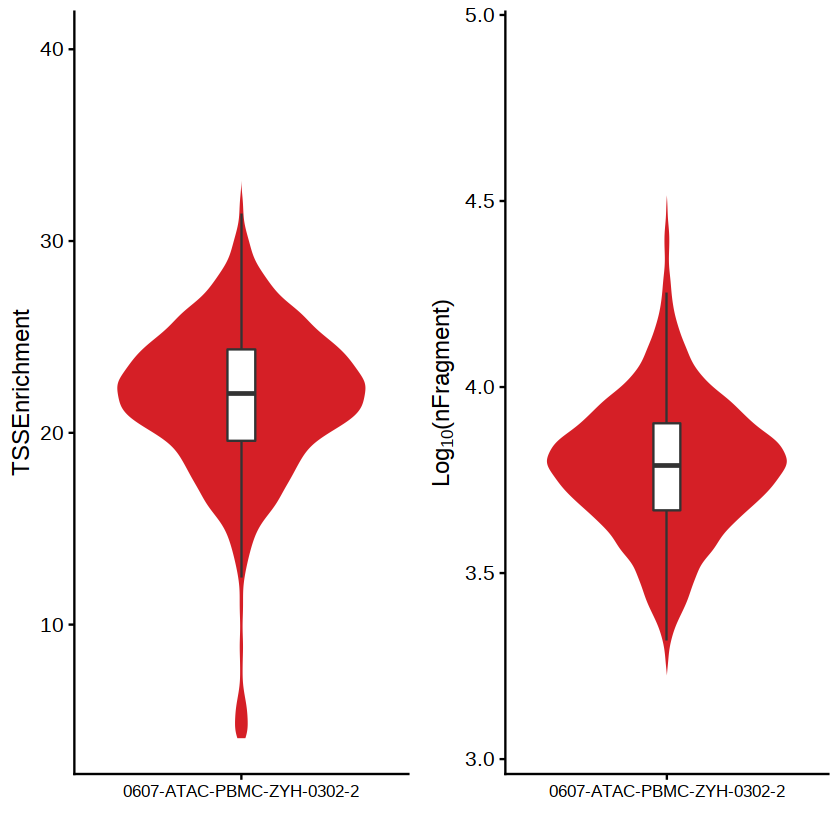

In [8]:
library(cowplot)
metadata <- as.data.frame(raw_proj@cellColData)
colours <- ArchR:::paletteDiscrete( values = unique(metadata$Sample))

P1<- ggplot(metadata, aes(x = Sample, y = TSSEnrichment, fill=Sample)) + 
  geom_violin(trim=TRUE,color="white",show.legend = F) +
  geom_boxplot(width=0.1,position=position_dodge(0.9),show.legend = F,fill="white",outlier.size = 0,outlier.stroke = 0)+
  scale_fill_manual(values = colours)+
  theme_cowplot()+
  theme(axis.text.x=element_text(colour="black",family="Times",size=10))+
  ylab("TSSEnrichment")+xlab("")

P2<- ggplot(metadata, aes(x = Sample, y = log10(nFrags), fill=Sample)) + 
  geom_violin(trim=TRUE,color="white",show.legend = F) +
  geom_boxplot(width=0.1,position=position_dodge(0.9),show.legend = F,fill="white",outlier.size = 0,outlier.stroke = 0)+
  scale_fill_manual(values = colours)+
  theme_cowplot()+
  theme(axis.text.x=element_text(colour="black",family="Times",size=10))+
  ylab(expression(Log[10]*paste("(","nFragment",")",sep = "")))+xlab("")

P <- do.call(plot_grid,c(list(P1,P2),ncol=2,align = "h"))
P

fragment 分布情况


<img src="https://s2.loli.net/2022/08/23/JFmgSTyMX4zKnsw.jpg" width=300>

TSS Enrichment 分布情况

<img src="https://s2.loli.net/2022/08/23/tC53PiUfQL7JYHu.jpg" width=300>

#### 3.5.2 细胞过滤

In [9]:

# 根据nFragment以及TSSEnrichment的分布情况进行细胞过滤
proj <- raw_proj[which(raw_proj$nFrags > 3000 & raw_proj$TSSEnrichment >10),]

# 根据预测的双胞分值进行双胞过滤
proj <- filterDoublets(proj, filterRatio = 2)

# filterRatio 参数 过滤细胞数=filterRatio * cellnum * 0.05 ；1表示需要过滤的双胞比例为5%，2表示需要过滤的双胞比例为10%

Filtering 1037 cells from ArchRProject!

	0607-ATAC-PBMC-ZYH-0302-2 : 1037 of 7201 (14.4%)



### 3.6 降维

ArchR 在LSI 降维的方法上有些不同，ArchR 的默认 LSI 降维与 Timothy Stuart 在[Signac](https://satijalab.org/signac/)中引入的方法相关，该方法使`log(TF-IDF)`进行归一化。

LSI 降维的关键输入之一是起始矩阵。到目前为止，scATAC-seq 中的两种主要策略是（1）使用peak区域或（2）全基因组bin。然而，使用 LSI 的峰值区域本质上是具有挑战性的，因为在降维之前我们没有聚类peak。此外，在聚类之前调用全部细胞上的peak会掩盖特定于细胞类型的peak。此外，当将新样本添加到分析中时，联合peak都会发生变化，从而使该策略不太稳定。第二种策略，使用全基因组bin区域，通过使用一致且无偏的特征集（全基因组bin）来解决这些问题。然而，所有区域的所有细胞的全基因组bin矩阵可能变得非常大，500 bp 的 bin 所面临的挑战是会生成大约 600 万个特征，因此，大多数方法使用大于或等于 5 kb 的bin（例如SnapATAC）。但是大多数可访问区域只有几百个碱基对长，5kb的bin将会掩盖一些细胞间开放区域差异。

ArchR的做法是将近600 万个特征矩阵存储在ArrowFiles中，并在降维时通过读取ArrowFiles，促使ArchR对全基因组 500 bp bin 的细胞矩阵非常快速地执行 LSI降维。这种方法解决了分辨率问题，并允许在peak calling之前进行聚类。 此外, ArchR还使用一种"估计 LSI"方法，该方法对总单元的子集执行初始降维。这种估计的 LSI 方法有两个主要用途 - (i) 它加快了降维速度；(ii) 当您减少在初始降维中使用的单元数时，这会降低数据的粒度。这种粒度的降低可以减少数据中的批次效应。但也可能掩盖真正的生物学，因此估计的 LSI 方法应在密切的人工监督下使用。

<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/LSI.png">

In [10]:

proj <- addIterativeLSI(
    ArchRProj = proj,
    useMatrix = "TileMatrix",
    name = "IterativeLSI",
    iterations = 5,#用户可查看每次迭代后的结果是否符合预期来选择迭代次数
    clusterParams = list( #See","Seurat::FindSample
        resolution = c(0.2),
        sampleCells = 10000,#downsampleing 1000个细胞进行
        n.start = 10
    ),
    varFeatures = 25000,
    dimsToUse = 1:30,
    force = T
)
mem_used()

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-3a53663f54-Date-2022-08-23_Time-03-46-46.log
If there is an issue, please report to github with logFile!

2022-08-23 03:46:47 : Computing Total Across All Features, 0.001 mins elapsed.

2022-08-23 03:46:47 : Computing Top Features, 0.017 mins elapsed.

###########
2022-08-23 03:46:49 : Running LSI (1 of 5) on Top Features, 0.045 mins elapsed.
###########

2022-08-23 03:46:49 : Creating Partial Matrix, 0.045 mins elapsed.

2022-08-23 03:46:57 : Computing LSI, 0.179 mins elapsed.

2022-08-23 03:47:12 : Identifying Clusters, 0.423 mins elapsed.

2022-08-23 03:47:24 : Identified 9 Clusters, 0.625 mins elapsed.

2022-08-23 03:47:24 : Saving LSI Iteration, 0.625 mins elapsed.

2022-08-23 03:47:36 : Creating Cluster Matrix on the total Group Features, 0.825 mins elapsed.

2022-08-23 03:47:44 : Computing Variable Features, 0.953 mins elapsed.

###########
2022-08-23 03:47:44 : Running LSI (2 of 5) on Variable Features, 0.95

815 MB

### 3.7 无监督的聚类

In [11]:

proj <- addClusters(
    input = proj,
    reducedDims = "IterativeLSI",
    method = "Seurat",
    name = "Clusters",
    resolution = 0.8,
    maxClusters = 35,
    force = T
)

ArchR logging to : ArchRLogs/ArchR-addClusters-3a6c7cfbad-Date-2022-08-23_Time-03-51-02.log
If there is an issue, please report to github with logFile!

2022-08-23 03:51:02 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6164
Number of edges: 244355

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8623
Number of communities: 15
Elapsed time: 0 seconds


2022-08-23 03:51:14 : Testing Biased Clusters, 0.189 mins elapsed.

2022-08-23 03:51:14 : Testing Outlier Clusters, 0.19 mins elapsed.

2022-08-23 03:51:14 : Assigning Cluster Names to 15 Clusters, 0.19 mins elapsed.

2022-08-23 03:51:14 : Finished addClusters, 0.191 mins elapsed.



### 3.8 可视化

In [12]:

proj <- addUMAP(
    ArchRProj = proj,
    reducedDims = "IterativeLSI",
    name = "UMAP",
    nNeighbors = 30,
    minDist = 0.5,
    metric = "cosine", force = T
)
mem_used()

03:51:19 UMAP embedding parameters a = 0.583 b = 1.334

03:51:19 Read 6164 rows and found 30 numeric columns

03:51:19 Using Annoy for neighbor search, n_neighbors = 30

03:51:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

03:51:20 Writing NN index file to temp file /tmp/RtmpecyfKz/file3a6ee557b1

03:51:20 Searching Annoy index using 8 threads, search_k = 3000

03:51:20 Annoy recall = 100%

03:51:21 Commencing smooth kNN distance calibration using 8 threads
 with target n_neighbors = 30

03:51:22 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

03:51:22 Using 'irlba' for PCA

03:51:22 PCA: 2 components explained 44.86% variance

03:51:22 Scaling init to sdev = 1

03:51:22 Commencing optimization for 500 epochs, with 261444 po

816 MB

### 3.9 对于多样本去批次

In [13]:

# proj <- addHarmony(
#     ArchRProj = proj,
#     reducedDims = "IterativeLSI",
#     name = "Harmony",
#     groupBy = "Sample",force = T
# )
# proj <- addClusters(
#     input = proj,
#     reducedDims = "Harmony",
#     method = "Seurat",
#     name = "Harmony_Clusters",
#     maxClusters = 35,
#     resolution = 0.8,force = T
# )
# proj <- addUMAP(
#     ArchRProj = proj,
#     reducedDims = "Harmony",
#     name = "UMAPHarmony",
#     nNeighbors = 30,
#     minDist = 0.5,
#     metric = "cosine",force = T
# )

绘制dimplot

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3a36f1046d-Date-2022-08-23_Time-03-51-38.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3a36f1046d-Date-2022-08-23_Time-03-51-38.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3a369b13af-Date-2022-08-23_Time-03-51-38.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3a369b13af-Date-2022-08-23_Time-03-51-38.log



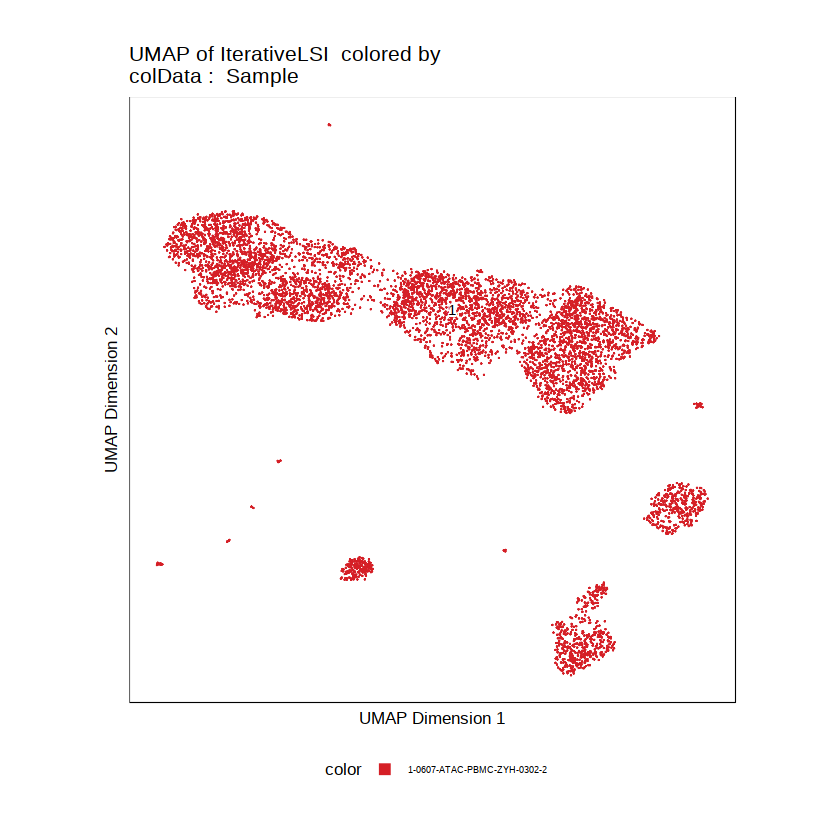

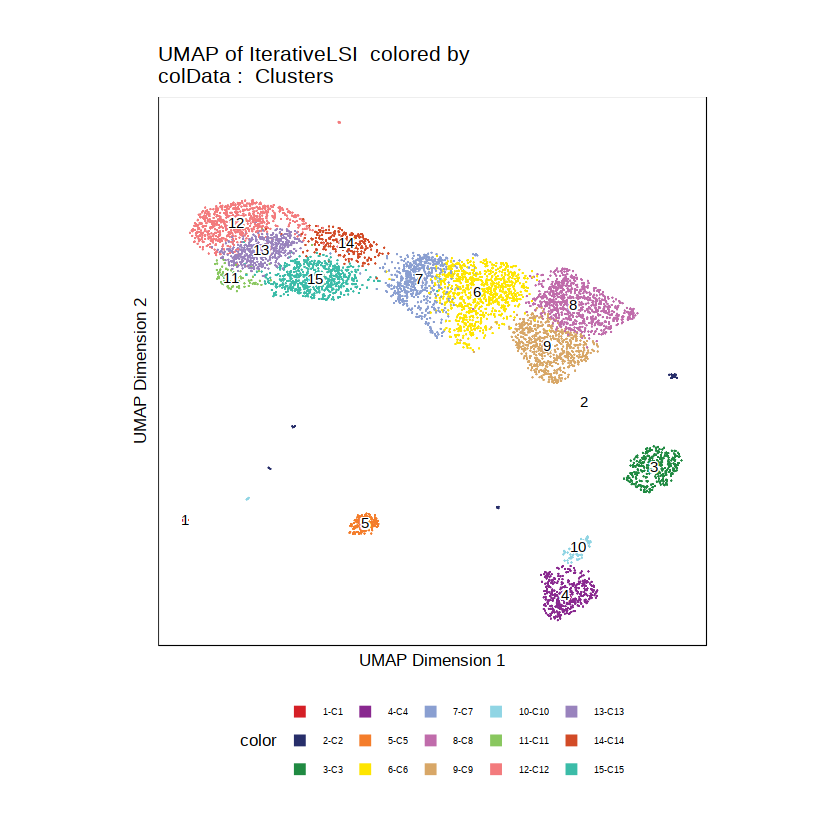

In [14]:

p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")

p1
p2
#plotPDF(p1,p2,p3,p4, name = "Filtered-cell-UMAP2Harmony-Sample-Sample.pdf", ArchRProj = proj, addDOC = FALSE, width = 5, height = 5)


### 3.10 获取每个无监督聚类的marker genes

ArchR获取GeneActivityScore Matrix
Gene Activity Score 计算主要包含三个方面：
1.    位于gene body区域的fragment全部参与Gene Activity Score的计算。
2.    使用加权函数，距离不同的fragment对Gene Activity Score有不同的贡献度。
3.    使用基因边界，使不相关的调控元件对基因评分的贡献最小化。

<center>
<img src="https://southpublic-database.obs.cn-south-1.myhuaweicloud.com/document/scRNA_camp/GeneActivityScore_Schematic.png" width="800">
</center>

#### 3.10.1 使用MAGIC对gene activity score 进行降噪

在scATAC-seq数据中，一个特定位置具有两种状态，一种是开放，这一种是不开放。由于技术限制及其他一系列的原因导致scATAC-seq比scRNA-seq更加稀疏。从而导致一些基因的activity score被噪音覆盖。为去除噪音影响，使用基于流行学习的MAGIC通过平滑附近细胞的信号来推断基因评分。

In [15]:

proj <- addImputeWeights(
  ArchRProj = proj,
  reducedDims = "IterativeLSI",
  dimsToUse = NULL,
  scaleDims = NULL,
  corCutOff = 0.75,
  td = 3,
  ka = 4,
  sampleCells = 1000,
  nRep = 2,
  k = 15,
  epsilon = 1,
  useHdf5 = TRUE,
  randomSuffix = FALSE,
  threads = getArchRThreads(),
  seed = 1,
  verbose = TRUE,
  logFile = createLogFile("addImputeWeights")
)



ArchR logging to : ArchRLogs/ArchR-addImputeWeights-3af417d13-Date-2022-08-23_Time-03-51-46.log
If there is an issue, please report to github with logFile!

2022-08-23 03:51:46 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



#### 3.10.2 获取marker genes

为了根据GeneActivityScore获取标记基因，我们将**`getMarkerFeatures()`**函数称为**`useMatrix = "GeneScoreMatrix"`**。我们指定我们想知道集群特定的特征，**`groupBy = "Clusters"`**它告诉 ArchR 使用"Cluster"列**`cellColData`**来对细胞进行分组

In [16]:

markersGS <- getMarkerFeatures(
    ArchRProj = proj,
    useMatrix = "GeneScoreMatrix",
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

#保存每个cluster的markgenes到tsv文件中
markerList <- getMarkers(markersGS)
markerList$C2
for (i in names(markerList)){if(dim(markerList[[i]])[1] > 0){markerList[[i]]$cluster <- i}}
b <- do.call(rbind,markerList)
#write.table(b,file="cortex_filtered_markergene_list.tsv",quote=F,row.names=F,sep="\t")


ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-3a84d3fce-Date-2022-08-23_Time-03-51-59.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2022-08-23 03:51:59 : Matching Known Biases, 0.001 mins elapsed.

###########
2022-08-23 03:52:56 : Completed Pairwise Tests, 0.95 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-3a84d3fce-Date-2022-08-23_Time-03-51-59.log



DataFrame with 274 rows and 9 columns
      seqnames     start       end  strand    name     idx    Log2FC        FDR
         <Rle>   <array>   <array> <array> <array> <array> <numeric>  <numeric>
1872      chr1 178513077 178548602       1   TEX35    1872   7.02151 0.00127198
5767     chr12  71839707  71927248       1 TBC1D15     782   3.66888 0.00455264
9088     chr16  56452199  56429133       2  NUDT21     603   2.94407 0.00455264
20856     chr6 159045152 159034468       2   TAGAP    1201   2.33540 0.00455264
14407     chr2 231961245 232344350       1  DIS3L2    1458   2.90435 0.00529601
...        ...       ...       ...     ...     ...     ...       ...        ...
16395     chr3  42600614  42648741       1    NKTR     263   1.36323  0.0983815
3863     chr11  35662805  35818007       1  TRIM44     441   2.49126  0.0984945
20564     chr6 109094819 108986437       2   SESN1     909   2.22789  0.0990399
22858     chr8 141117278 141195808       1  DENND3     778   1.03892  0.0991623
20

绘制已知marker gene的feature plot

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3a4cca3c32-Date-2022-08-23_Time-03-53-04.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2022-08-23 03:53:04 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3a4cca3c32-Date-2022-08-23_Time-03-53-04.log

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guide

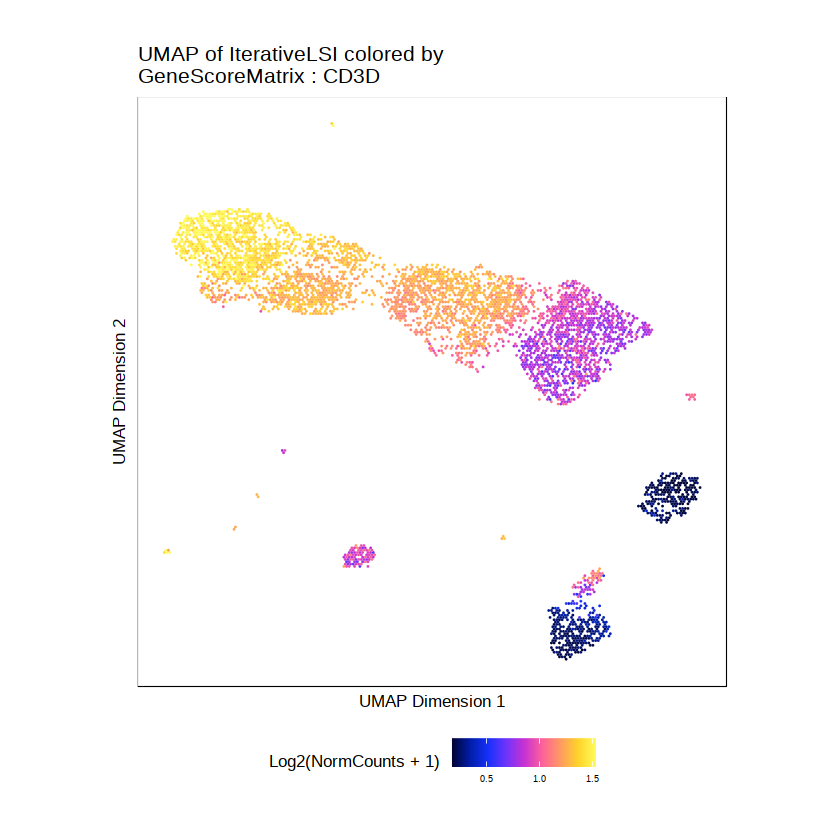

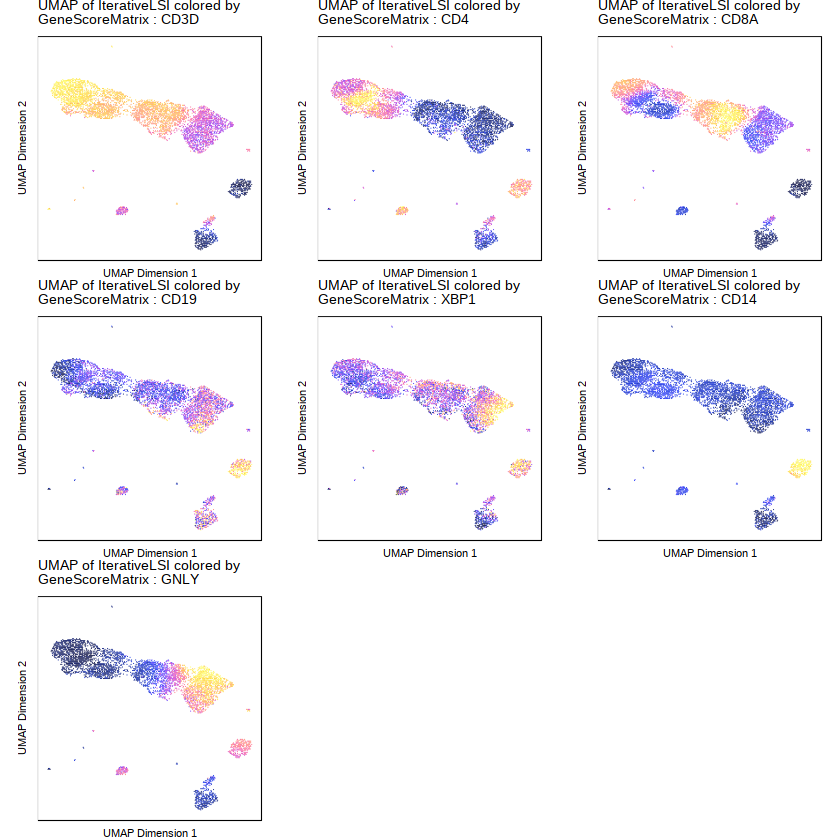

In [17]:

#绘制期望基因的DimPlot
markerGenes  <- c(
    "CD3D","CD4","CD8A",  #T cells
    "CD19", #B cells
    "XBP1", #plasma 
    "CD14", #Monocytes
    "GNLY" # NK cells
  )
p <- plotEmbedding(
        ArchRProj = proj,
        colorBy = "GeneScoreMatrix",
        name = markerGenes,
        embedding = "UMAP",
        imputeWeights = getImputeWeights(proj)
    )

p$CD3D

p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

# plotPDF(plotList = p,
# name = paste0("Plot-filtered-UMAP-",names(marker_list[x]),"-W-Imputation.pdf"),
# ArchRProj = proj,
# addDOC = FALSE, width = 5, height = 5)

### 3.11 细胞类型注释

In [18]:

# 根据marker genes进行注释
markerGenes  <- c(
    "CD3D","CD4","CD8A",  #T cells
    "CD19", #B cells
    "XBP1", #plasma 
    "CD14", #Monocytes
    "GNLY" # NK cells
  )
# 通过scRNA transfer进行注释
load('/opt/example/pbmc3k.rda')
#library(Seurat)
#library(SeuratData)
#InstallData("pbmc3k")
#library(pbmc3k.SeuratData)
#data("pbmc3k")

seRNA <- pbmc3k
seRNA@active.assay <- "RNA"
proj <- addGeneIntegrationMatrix(
    ArchRProj = proj,
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = FALSE,
    groupRNA = "seurat_annotations",
    nameCell = "predictedsubCell",
    nameGroup = "predictedsubGroup",
    nameScore = "predictedsubScore"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-3a26915e37-Date-2022-08-23_Time-03-53-51.log
If there is an issue, please report to github with logFile!

2022-08-23 03:53:51 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2022-08-23 03:53:51 : Checking ATAC Input, 0.001 mins elapsed.

2022-08-23 03:53:51 : Checking RNA Input, 0.002 mins elapsed.

2022-08-23 03:53:53 : Found 11718 overlapping gene names from gene scores and rna matrix!, 0.024 mins elapsed.

2022-08-23 03:53:53 : Creating Integration Blocks, 0.024 mins elapsed.

2022-08-23 03:53:53 : Prepping Interation Data, 0.024 mins elapsed.

2022-08-23 03:53:53 : Computing Integration in 1 Integration Blocks!, 0 mins elapsed.

2022-08-23 03:53:53 : Block (1 of 1) : Computing Integration, 0 mins elapsed.

2022-08-23 03:53:53 : Block (1 of 1) : Identifying Variable Genes, 0.003 mins elapsed.

2022-08-23 03:53:54 : Block (1 of 1) : Getting GeneScoreMatrix, 0.014 mins elapsed.

2022-08-23 03:54:00 : B

绘制预测细胞类型的DimPlot

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3a4ecea683-Date-2022-08-23_Time-03-55-47.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3a4ecea683-Date-2022-08-23_Time-03-55-47.log



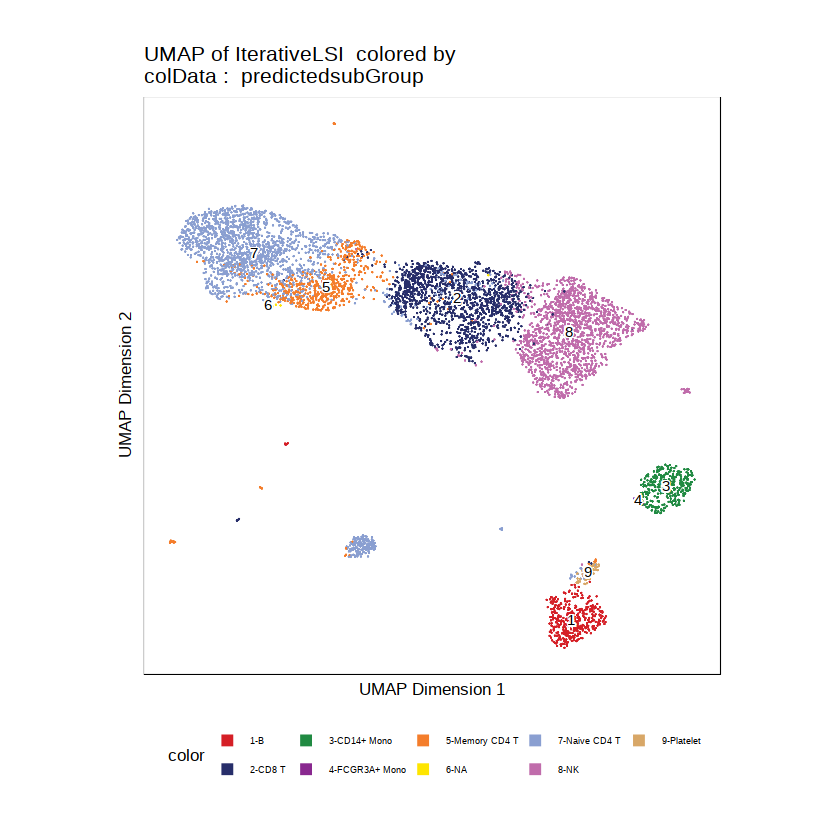

In [19]:

#绘制预测细胞类型的DimPlot
p3 <- plotEmbedding(
    proj,
    colorBy = "cellColData",
    name = "predictedsubGroup",
    embedding = "UMAP"
 )

p3


In [20]:
saveRDS(proj,'proj.RDS')

In [21]:
proj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/jovyan/tutorial 
samples(1): 0607-ATAC-PBMC-ZYH-0302-2
sampleColData names(1): ArrowFiles
cellColData names(19): Sample TSSEnrichment ... predictedsubGroup
  predictedsubScore
numberOfCells(1): 6164
medianTSS(1): 22.262
medianFrags(1): 6203.5

In [22]:
getwd()

[1] "/home/jovyan"